C:\Users\AKSHAY\AppData\Local\Temp\ipykernel_22152\1232380121.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train = train.astype('float16')  # Explicitly cast to float32
C:\Users\AKSHAY\AppData\Local\Temp\ipykernel_22152\1232380121.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test = test.astype('float16')   # Explicitly cast to float32


98604/98604 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step - loss: 0.0161
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 94s 952us/step - loss: 9.1376e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 98s 992us/step - loss: 9.0358e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 98s 992us/step - loss: 8.9974e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 101s 1ms/step - loss: 8.9729e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - loss: 8.9573e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 110s 1ms/step - loss: 8.9447e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 126s 1ms/step - loss: 0.0103
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 125s 1ms/step - loss: 9.1819e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 126s 1ms/step - loss: 9.0453e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 125s 1ms/step - loss: 9.0029e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 129s 1ms/step - loss: 8.9864e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 137s 1ms/step - loss: 8.9697e-04
98604/98604 ━━━━━━━━━━━━━━━━━━━━ 144s 1ms/step - loss: 8.9508e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1

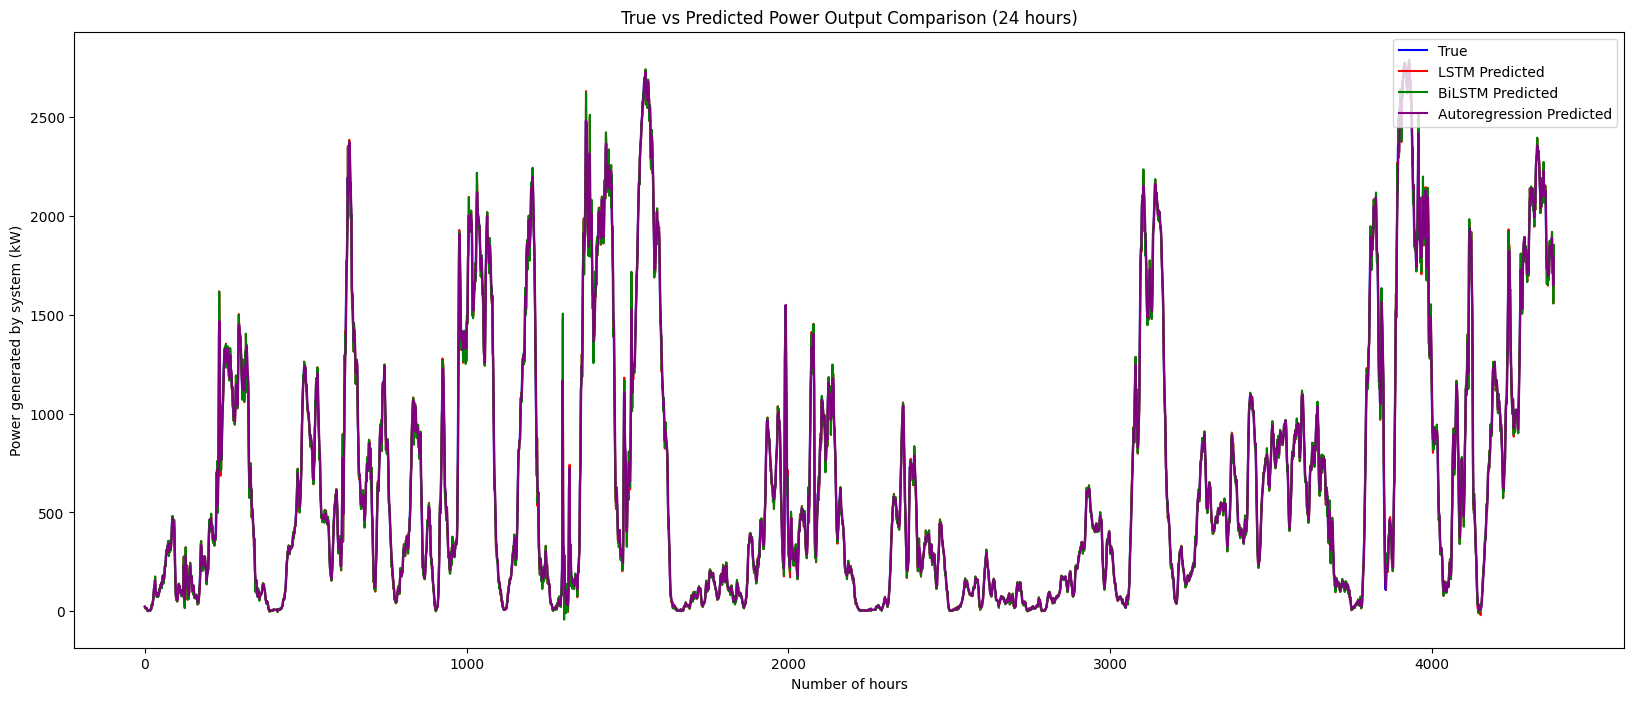

In [1]:
from pandas import DataFrame, Series, concat
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Hardcoded parameters
batch_size_exp = 2
epoch_exp = 7
neurons_exp = 50
predict_values_exp = 4380
lag_exp = 24

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.astype('float16')  # Explicitly cast to float32
    test = test.astype('float16')   # Explicitly cast to float32
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

from keras.layers import InputLayer

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # Ensure input data is float32
    X, y = X.astype('float16'), y.astype('float16')
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(InputLayer(batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    lstm_layer = LSTM(neurons, stateful=True)
    model.add(lstm_layer)
    model.add(Dense(1, dtype='float16'))  # Output is explicitly float32
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        lstm_layer.reset_states()

    return model

# fit a BiLSTM network to training data
def fit_bilstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # Ensure input data is float32
    X, y = X.astype('float16'), y.astype('float16')
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(InputLayer(batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    bilstm_layer = Bidirectional(LSTM(neurons, stateful=True))
    model.add(bilstm_layer)
    model.add(Dense(1, dtype='float16'))  # Output is explicitly float32
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        bilstm_layer.reset_states()

    return model


# fit an AutoRegression model
def fit_autoreg(train, lags=lag_exp):
    raw_values = train[:, -1]
    model = AutoReg(raw_values, lags=lags)
    model_fit = model.fit()
    return model_fit

# make a one-step forecast for LSTM/BiLSTM
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

# make a one-step forecast for AutoRegression
def forecast_autoreg(model_fit, history):
    return model_fit.predict(start=len(history), end=len(history), dynamic=False)[0]

''' Loading data '''
import pandas as pd
series = pd.read_excel('data.xlsx',index_col="timestamp")
series.head()

# Preprocess data
for i in range(0, 10):
    series = series[:-1]

raw_values = series.values
diff_values = difference(raw_values, 1)
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit models
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)
bilstm_model = fit_bilstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)
autoreg_model_fit = fit_autoreg(train_scaled, lags=lag_exp)

# walk-forward validation on test data for LSTM, BiLSTM, and AutoRegression
predictions_lstm, predictions_bilstm, predictions_autoreg, expectations = [], [], [], []
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]

    # LSTM prediction
    yhat_lstm = forecast_lstm(lstm_model, 1, X)
    yhat_lstm = invert_scale(scaler, X, yhat_lstm)
    yhat_lstm = inverse_difference(raw_values, yhat_lstm, len(test_scaled)+1-i)
    predictions_lstm.append(yhat_lstm)

    # BiLSTM prediction
    yhat_bilstm = forecast_lstm(bilstm_model, 1, X)
    yhat_bilstm = invert_scale(scaler, X, yhat_bilstm)
    yhat_bilstm = inverse_difference(raw_values, yhat_bilstm, len(test_scaled)+1-i)
    predictions_bilstm.append(yhat_bilstm)

    # Autoregression prediction
    yhat_autoreg = forecast_autoreg(autoreg_model_fit, raw_values[:len(train) + i + 1])
    yhat_autoreg = inverse_difference(raw_values, yhat_autoreg, len(test_scaled)+1-i)
    predictions_autoreg.append(yhat_autoreg)

    # expected value
    expectations.append(raw_values[len(train) + i + 1])

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Utility functions for metrics
def calculate_rmse(expected, predicted):
    return np.sqrt(mean_squared_error(expected, predicted))

def calculate_mape(expected, predicted):
    expected, predicted = np.array(expected), np.array(predicted)
    non_zero_idx = expected != 0
    return np.mean(np.abs((expected[non_zero_idx] - predicted[non_zero_idx]) / expected[non_zero_idx])) * 100

# Calculate metrics
def evaluate_model(expectations, predictions, model_name):
    r2 = r2_score(expectations, predictions)
    mse = mean_squared_error(expectations, predictions)
    rmse = calculate_rmse(expectations, predictions)
    mae = mean_absolute_error(expectations, predictions)
    mape = calculate_mape(expectations, predictions)

    print(f"{model_name} Metrics:")
    print(f"  R²: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print("\n")
    return r2, mse, rmse, mae, mape

# Evaluate models
evaluate_model(expectations, predictions_lstm, "LSTM")
evaluate_model(expectations, predictions_bilstm, "BiLSTM")
evaluate_model(expectations, predictions_autoreg, "AutoRegression")

# Plot comparison
plt.figure(figsize=(20, 8))
plt.plot(expectations, label="True", color="blue")
plt.plot(predictions_lstm, label="LSTM Predicted", color="red")
plt.plot(predictions_bilstm, label="BiLSTM Predicted", color="green")
plt.plot(predictions_autoreg, label="Autoregression Predicted", color="purple")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("Power generated by system (kW)")
plt.title("True vs Predicted Power Output Comparison (24 hours)")
plt.show()